In [3]:
import torch
import clip
from PIL import Image
import os
from os.path import join, isdir, expanduser
from tqdm import tqdm

data_path = expanduser('~/datasets')

# need to adapt locally

raw_image_path = ["share", "raw_images"]
construction_path = ["share", "construction"]
finished_path = ["share", "finished"]

image_files = os.listdir(join(data_path, *construction_path))


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [ ]:
# Test CLIP performance for keyword sentences with already correctly separated images 

num_images = 10

# Prepare the inputs
raw_image_batch = [Image.open(join(data_path, *construction_path, f))
          for f in tqdm(image_files[:num_images], desc="Raw Images loading") if f.endswith('.jpg')]

# image = raw_image_batch[1]
images = raw_image_batch

classes=["building in construction", "finished building"]

pp_images = [preprocess(img) for img in images]

for img in pp_images:
    image_input = img.unsqueeze(0).to(device)
    # image_input = preprocess(images).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a image of a {c}") 
                                 for c in classes]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(2)

    # Print the result
    print("\nTop predictions:\n")
    for value, index in zip(values, indices):
        print(f"{classes[index]}: {100 * value.item():.2f}%")


In [ ]:
import requests
import pandas as pd
from io import BytesIO
from PIL import UnidentifiedImageError

def save_file(path, filename):
    if os.path.exists(join(path, filename)):
        save_file(path, "0"+filename)
    else:
        file = open(join(path, filename), "wb")
        file.write(response.content)
        file.close()


classes=["skyscraper in construction", "finished skyscraper", "construction site"]

# data = pd.read_csv(join(data_path, "share", "buildingconstruction.tsv"),
#                    sep="\t", error_bad_lines=False)
# data = data.rename(columns={
#                    'http://farm4.staticflickr.com/3055/2330466409_fc8133ec39.jpg': 'image_url'})

data = pd.read_csv(join(data_path, "share", "skyscraper.tsv"),
                   sep="\t", error_bad_lines=False)
data = data.rename(columns={
                   'http://farm3.staticflickr.com/2384/3543591719_b5f2cf8c98.jpg': 'image_url'})

# data = data.rename(columns={
#    'http://farm3.staticflickr.com/2384/3543591719_b5f2cf8c98.jpg': 'image_url'})
data = data['image_url']
# print(len(data.tolist()))

for i, url in enumerate(data.tolist()[0:10000]):
    # response = requests.get("https://i.imgur.com/ExdKOOz.png")
    try:
        response = requests.get(url)
    except requests.exceptions.MissingSchema as err:
        print(err)
        continue
        
    try:
        img = Image.open(BytesIO(response.content))
    except UnidentifiedImageError:
        continue

    
    image_input = preprocess(img).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a image of a {c}") 
                                 for c in classes]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(2)

    # save image if it is more likely to be finished
    if indices[0] == 1:
        # save_file(join(data_path, *construction_path), f"{i}.jpg")
        save_file(join(data_path, *finished_path), f"{i}.jpg")
        

        # Print the result
        print("\nTop predictions:\n")
        for value, index in zip(values, indices):
            print(f"{classes[index]}: {100 * value.item():.2f}%")


In [15]:
clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
from PIL import Image
import requests
from io import BytesIO
url = 'https://farm4.staticflickr.com/3055/2330466409_fc8133ec39.jpg'
response = requests.get(url)
file = open(join(data_path, *construction_path, f"{1}.jpg"), "wb")
file.write(response.content)
file.close()

# img = Image.open(BytesIO(response.content))
# img

In [1]:
image_files = os.listdir(join(data_path, *construction_path))
for i in image_files:
    print(i)

NameError: name 'os' is not defined

Training a Clip Model

In [29]:
model.parameters()


<generator object Module.parameters at 0x7f8bafb22f90>

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
data_path = expanduser('~/datasets')

from datetime import datetime
from time import time, sleep

path_training_img_path = ["share", "clip_training_construction"]


In [88]:
prompt_list = ['building in construction', 'finished building', 'construction site', 'tree', 'car', 'city', 'cat', 'dog']
image_files = [img for img in os.listdir(join(data_path, *path_training_img_path)) if img.endswith('.jpg')]

len(image_files)

1

In [ ]:
# TO ADD :
# Gradient Checkpointing
# Filter out bias from weight decay
# Decaying learning rate with cosine schedule
# Half-precision Adam statistics
# Half-precision stochastically rounded text encoder weights were used

BATCH_SIZE = 1

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

class image_title_dataset(Dataset):
    def __init__(self, list_image,list_txt,img_path=join(data_path, *path_training_img_path)):

        self.list_image = list_image
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.
        self.img_path = img_path
    def __len__(self):
        return len(self.list_image)

    def __getitem__(self, idx):
        # print(f"idx is {idx}")
        image = preprocess(Image.open(join(self.img_path, self.list_image[idx]))) # Image from PIL module
        title = self.title[idx]
        return image,title

# use your own data
# path_training_img_path = ["share", "clip_training_construction"]

image_files = [img for img in os.listdir(join(data_path, *path_training_img_path)) if img.endswith('.jpg')]
prompt_list = ['building under construction', 'finished building', 'construction site', 'tree', 'car', 'city', 'cat', 'dog']
prompt_list = [f'a photo of a {img_class}' for img_class in prompt_list]
print(prompt_list)
# list_image_path = ['folder/image1.jpg','folder2/image2.jpg'] 
# list_txt = ['description for image1.jpg' , 'description for image2.jpg']
dataset = image_title_dataset(image_files,prompt_list)
train_dataloader = DataLoader(dataset,batch_size = BATCH_SIZE, shuffle=True) #Define your own dataloader

#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


# if device == "cpu":
#   model.float()
# else :
#   clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

epochs = 60

#define image to optimize over

image_file = preprocess(Image.open(join(data_path, *path_training_img_path, image_files[0])))

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam([image_file], lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset


train_loss = []

for epoch in range(epochs):
    epoch_loss = []
    for i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        images,texts = batch 

        images= images.to(device)
        texts = texts.to(device)
        # print(f"type {type(texts)}")
        # print(f"type {texts}")
        logits_per_image, logits_per_text = model(images, texts)
        
        # ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        ground_truth = torch.tensor([0], dtype=torch.long).to(device)
        # ground_truth = torch.flatten(ground_truth.expand(8,1).to(device))
        
        
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        epoch_loss.append(total_loss)
        
        if epoch % 5 == 4:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, (sum(epoch_loss) / len(epoch_loss))))
        
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else: 
            convert_models_to_fp32(model)
            optimizer.step()
            # convert back to fp16
            clip.model.convert_weights(model)
    train_loss.append((sum(epoch_loss) / len(epoch_loss)).detach().cpu().numpy())


In [145]:
# Train over image

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

image_files = [img for img in os.listdir(join(data_path, *path_training_img_path)) if img.endswith('.jpg')]
prompt_list = ['building under construction', 'finished building', 'construction site', 'tree', 'car', 'city', 'cat', 'dog']
prompt_list = [f'a photo of a {img_class}' for img_class in prompt_list]
print(prompt_list)

def saver(clip, exp_id = ""):
    now = datetime.now()
    time = now.strftime("%m.%d._%H:%M")
    
    path = os.path.join("saves", exp_id, time)
    
    os.makedirs(path)
    
    torch.save(clip.state_dict(), os.path.join(path, "clip" + ".pth"))

def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        # p.grad.data = p.grad.data.float() 

epochs = 200

#define image to optimize over
image_file = preprocess(Image.open(join(data_path, *path_training_img_path, image_files[0])))
# pre_img = image_file.clone()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

train_loss = []

for p in model.parameters():
    p.requires_grad = False

image_file.requires_grad = True

# optimizer = optim.Adam([image_file], lr=5e-3,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
optimizer = optim.Adam([image_file], lr=0.001)

last_save = time()

for epoch in range(epochs):
    epoch_loss = []
    
    optimizer.zero_grad()

    images,texts = image_file,prompt_list 

    images= images.unsqueeze(0).to(device)
    texts = clip.tokenize(texts).to(device)

    logits_per_image, logits_per_text = model(images, texts)

    ground_truth = torch.tensor([0], dtype=torch.long).to(device)
    ground_truth_text = torch.flatten(ground_truth.expand(8,1).to(device))
    
    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth_text))/2
    epoch_loss.append(total_loss)

    if epoch % 10 == 9:    
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, (sum(epoch_loss) / len(epoch_loss))))

    total_loss.backward()
    if device == "cpu":
        optimizer.step()
    else: 
        convert_models_to_fp32(model)
        optimizer.step()
        # convert back to fp16
        clip.model.convert_weights(model)
    # save model after every 100 epochs
    
    if time() - last_save >= 300:
        last_save = time()
        saver(model, "01_Clip")

    

    train_loss.append((sum(epoch_loss) / len(epoch_loss)).detach().cpu().numpy())
saver(model, "01_Clip")


['a photo of a building under construction', 'a photo of a finished building', 'a photo of a construction site', 'a photo of a tree', 'a photo of a car', 'a photo of a city', 'a photo of a cat', 'a photo of a dog']
[10,     1] loss: 0.010
[20,     1] loss: 0.005
[30,     1] loss: 0.004
[40,     1] loss: 0.003
[50,     1] loss: 0.002
[60,     1] loss: 0.002
[70,     1] loss: 0.001
[80,     1] loss: 0.001
[90,     1] loss: 0.001
[100,     1] loss: 0.001
[110,     1] loss: 0.001
[120,     1] loss: 0.001
[130,     1] loss: 0.001
[140,     1] loss: 0.001
[150,     1] loss: 0.001
[160,     1] loss: 0.000
[170,     1] loss: 0.000
[180,     1] loss: 0.000
[190,     1] loss: 0.000
[200,     1] loss: 0.000


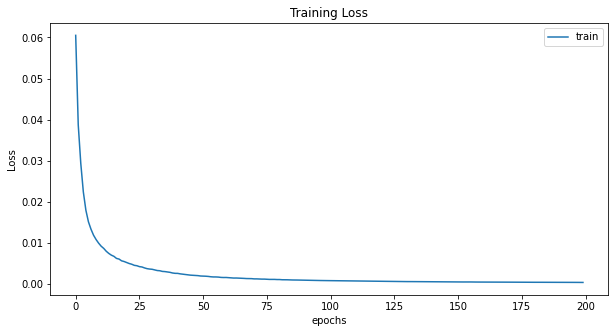

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training Loss")
# plt.plot(val_losses,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Compare Performance with untrained Clip model on dataset:

In [6]:
construction_path = ["share", "Florian_Jonas_construction"]
finished_path = ["share", "Florian_Jonas_finished"]

image_files = os.listdir(join(data_path, *construction_path))

untrained_model, preprocess = clip.load("ViT-B/32", device=device)

trained_model, _ = clip.load("ViT-B/32", device=device)

trained_model_path = os.path.join("saves", "01_Clip", "06.22._00:35")
trained_model.load_state_dict(torch.load(os.path.join(trained_model_path, "clip" + ".pth")))


<All keys matched successfully>

In [7]:
num_images = 50

# Prepare the inputs
raw_image_batch = [Image.open(join(data_path, *construction_path, f))
          for f in tqdm(image_files[:num_images], desc="Raw Images loading") if f.endswith('.jpg')]

images = raw_image_batch

classes = ['building under construction', 'finished building', 'construction site', 'tree', 'car', 'city', 'cat', 'dog']

pp_images = [preprocess(img) for img in images]

top_one_accuracy_untrained_model = 0
top_one_accuracy_trained_model = 0
total = 1

for img in pp_images:
    image_input = img.unsqueeze(0).to(device)
    # image_input = preprocess(images).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a image of a {classes}") 
                                 for c in classes]).to(device)
    
    # untrained model:
    
    # Calculate features
    with torch.no_grad():
        image_features = untrained_model.encode_image(image_input)
        text_features = untrained_model.encode_text(text_inputs)

    # Pick the top 3 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(3)

    if (indices[0] == 0):
        top_one_accuracy_untrained_model += 1
    for value, index in zip(values,indices): 
        print(f"{classes[index]}: {100 * value.item():.2f}%")
        
        
    # trained model:
    
    with torch.no_grad():
        image_features = trained_model.encode_image(image_input)
        text_features = trained_model.encode_text(text_inputs)

    # Pick the top 3 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(3)

    if (indices[0] == 0):
        top_one_accuracy_trained_model += 1
    total += 1
    for value, index in zip(values,indices): 
        print(f"{classes[index]}: {100 * value.item():.2f}%")

print(f"Top-One Accuracy of not fine-tuned Clip: {(top_one_accuracy_untrained_model / total) * 100}% ")
print(f"Top-One Accuracy of fine-tuned Clip: {(top_one_accuracy_trained_model / total) * 100}% ")


Raw Images loading: 100%|█████████████████████| 50/50 [00:00<00:00, 3684.97it/s]


construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finished building: 12.50%
building under construction: 12.50%
construction site: 12.50%
finish

In [ ]:
# plt.figure(figsize=(10,5))
# plt.title("Testing Accuarcy")
# # plt.plot(val_losses,label="val")
# plt.plot(train_loss,label="train")
# plt.xlabel("epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [82]:
# Test training function for simplistic example
path_training_img_path = ["share", "clip_generic_example"]

BATCH_SIZE = 2

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

class image_title_dataset(Dataset):
    def __init__(self, list_image,list_txt,img_path=join(data_path, *path_training_img_path)):

        self.list_image = list_image
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.
        self.img_path = img_path
    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # print(f"idx is {idx}")
        image = preprocess(Image.open(join(self.img_path, self.list_image[idx]))) # Image from PIL module
        title = self.title[idx]
        return image,title

image_files = [img for img in os.listdir(join(data_path, *path_training_img_path)) if img.endswith('.jpg')]
prompt_list = ['cat', 'building under construction', 'dog', 'skyscraper']
prompt_list = [f'a photo of a {img_class}' for img_class in prompt_list]
print(prompt_list)

dataset = image_title_dataset(image_files,prompt_list)
train_dataloader = DataLoader(dataset,batch_size = BATCH_SIZE, shuffle=True) #Define your own dataloader

#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


epochs = 20

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

train_loss = []

for epoch in range(epochs):
    epoch_loss = []
    for i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        images,texts = batch 

        images= images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)
        
        # ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        # ground_truth = torch.flatten(ground_truth.expand(8,1).to(device))
        
        
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        epoch_loss.append(total_loss)
        
        if epoch % 10 == 9:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, (sum(epoch_loss) / len(epoch_loss))))
        
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else: 
            convert_models_to_fp32(model)
            optimizer.step()
            # convert back to fp16
            clip.model.convert_weights(model)

    train_loss.append((sum(epoch_loss) / len(epoch_loss)).detach().cpu().numpy())


['a photo of a cat', 'a photo of a building under construction', 'a photo of a dog', 'a photo of a skyscraper']
[5,     1] loss: 0.027
[5,     2] loss: 0.017
[10,     1] loss: 0.013
[10,     2] loss: 0.051
[15,     1] loss: 0.644
[15,     2] loss: 0.374
[20,     1] loss: 0.000
[20,     2] loss: 0.000


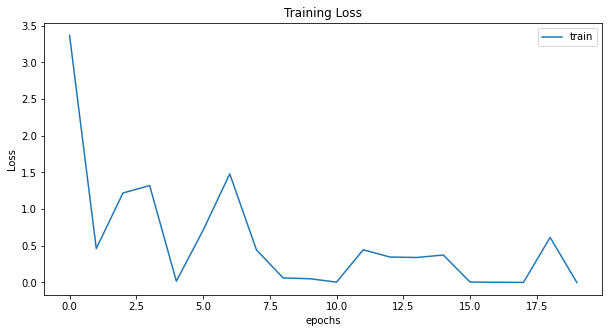

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training Loss")
# plt.plot(val_losses,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [77]:
# loss_img = nn.CrossEntropyLoss()
# t1 = torch.rand(4, 4,dtype=torch.float64)
# t2 = torch.rand(4,1)
# t2 = t2.type(torch.LongTensor)

t2 = torch.tensor([0], dtype=torch.long)
t2 = t2.expand(8,1)
torch.flatten(t2)

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
if epoch % 100 == 99:  
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': sum(epoch_loss) / len(epoch_loss),
    }, f"model_checkpoint/model_10.pt") 


In [ ]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("model_checkpoint/model_10.pt")

# Use these 3 lines if you use default model setting(not training setting) of the clip. For example, if you set context_length to 100 since your string is very long during training, then assign 100 to checkpoint['model_state_dict']["context_length"] 
checkpoint['model_state_dict']["input_resolution"] = model.input_resolution #default is 224
checkpoint['model_state_dict']["context_length"] = model.context_length # default is 77
checkpoint['model_state_dict']["vocab_size"] = model.vocab_size 

model.load_state_dict(checkpoint['model_state_dict'])


In [98]:
# check for expected number of images
path_training_img_path = ["share", "clip_training_construction"]

image_files = os.listdir(join(data_path, *path_training_img_path))
only_img = [i for i in image_files if i.endswith('jpg')]
len(only_img)
# for img in only_img:
    # os.rename(join(data_path,*path, img), join(data_path,*path,'construction_' + img[:-17] + '.jpg'))

1

In [ ]:
# Test if performance has improved with fine-tuned model:
